In [1]:
import sys,os
import torch
import yaml
import logging
from pydantic import ValidationError

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd()))))))
from datasets.weather_bench import WeatherDataset
from models.CiT.datasets.dataset import CustomDataset
from models.CiT.training.configs import TrainingConfig
from models.CiT.training.configs import TrainingRunConfig

def get_normal_dataset(config: TrainingConfig):
    device = ("cuda" if torch.cuda.is_available() else "cpu" )
    device = torch.device(device)

    weather = WeatherDataset(config.train_offset, device=device)
    # dataset.shape:  torch.Size([7309, 100, 1450])
    source, label, mean_std = weather.load(config.air_variable, config.surface_variable)
    dataset = CustomDataset(source, label, config.max_lead_time)
    var_list = weather.get_var_code(config.air_variable, config.surface_variable)
    return dataset, mean_std, var_list

config_path = os.path.join(os.path.dirname(os.getcwd()), 'configs/train_config.yaml')

try:
    with open(config_path) as f:
        config_dict = yaml.safe_load(f)
    config: TrainingRunConfig = TrainingRunConfig.parse_obj(config_dict)
except FileNotFoundError:
    logging.error(f"Config file {config_path} does not exist. Exiting.")
except yaml.YAMLError:
    logging.error(f"Config file {config_path} is not valid YAML. Exiting.")
except ValidationError as e:
    logging.error(f"Config file {config_path} is not valid. Exiting.\n{e}")


dataset, _, var_list = get_normal_dataset(config.training)

데이터셋 불러오는 중...
==== LOAD DATASET ====
 <xarray.Dataset>
Dimensions:                       (time: 87673, latitude: 30, longitude: 30,
                                   level: 37)
Coordinates:
  * latitude                      (latitude) float32 32.0 32.25 ... 39.0 39.25
  * level                         (level) int64 1 2 3 5 7 ... 925 950 975 1000
  * longitude                     (longitude) float32 124.0 124.2 ... 131.2
  * time                          (time) datetime64[ns] 2011-12-31 ... 2021-1...
Data variables: (12/15)
    10m_u_component_of_wind       (time, latitude, longitude) float32 dask.array<chunksize=(128, 30, 30), meta=np.ndarray>
    10m_v_component_of_wind       (time, latitude, longitude) float32 dask.array<chunksize=(128, 30, 30), meta=np.ndarray>
    2m_temperature                (time, latitude, longitude) float32 dask.array<chunksize=(128, 30, 30), meta=np.ndarray>
    geopotential                  (time, level, latitude, longitude) float32 dask.array<chunksize=(1

100%|██████████| 12/12 [00:43<00:00,  3.64s/it]


46.96182 sec
==== LOAD DATASET ====
 <xarray.Dataset>
Dimensions:                       (time: 87673, latitude: 20, longitude: 20,
                                   level: 37)
Coordinates:
  * latitude                      (latitude) float64 21.0 22.5 ... 48.0 49.5
  * level                         (level) int64 1 2 3 5 7 ... 925 950 975 1000
  * longitude                     (longitude) float64 115.5 117.0 ... 144.0
  * time                          (time) datetime64[ns] 2011-12-31 ... 2021-1...
Data variables: (12/15)
    10m_u_component_of_wind       (time, latitude, longitude) float32 dask.array<chunksize=(128, 20, 20), meta=np.ndarray>
    10m_v_component_of_wind       (time, latitude, longitude) float32 dask.array<chunksize=(128, 20, 20), meta=np.ndarray>
    2m_temperature                (time, latitude, longitude) float32 dask.array<chunksize=(128, 20, 20), meta=np.ndarray>
    geopotential                  (time, level, latitude, longitude) float32 dask.array<chunksize=(128, 

100%|██████████| 12/12 [00:19<00:00,  1.66s/it]


21.40502 sec


In [2]:
%load_ext autoreload
%autoreload 2

from models.CiT.training.lightning import TrainModule

model = TrainModule.load_from_checkpoint('/workspace/Haea_dev/models/CiT/tb_logs/lightning_logs/o9n1ye57/checkpoints/epoch=29-step=65730.ckpt')

/workspace/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [3]:
from torch.utils.data import DataLoader, Dataset
import tqdm

data_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=8)
errors = {key: [] for key in range(config.training.max_lead_time+1)}
epoch = 3

for _ in range(epoch):
    for i, batch in enumerate(tqdm.tqdm(data_loader)):
        _, _ , rmse_loss, delta = model(batch)
        # loss.shape = (batch, var_len)
        for i, d in enumerate(delta):
            errors[d.item()].append(rmse_loss[i])

  0%|          | 0/2740 [00:00<?, ?it/s]

100%|██████████| 2740/2740 [07:04<00:00,  6.46it/s]


In [7]:
print(errors.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])


In [4]:
# shape = (lead_time, count, var_len)
result = torch.zeros(config.training.max_lead_time, len(var_list))

for time in errors.keys():
    if len(errors[time]) > 0:
        mean = torch.stack(errors[time], dim=0).mean(dim=0)
        result[time] = mean

result = result.swapaxes(0, 1)

In [8]:
print(result.shape)

torch.Size([228, 28])


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize(loss: torch.Tensor, title):
    print(loss.min())
    plt.plot(loss, label="rmse loss")
    plt.title(title)
    plt.show()

tensor(3.0472)


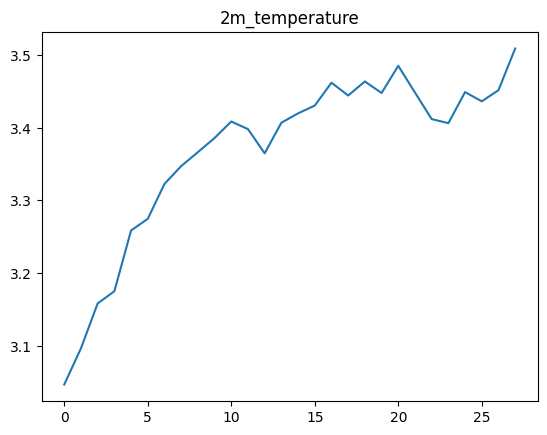

tensor(2.5673)


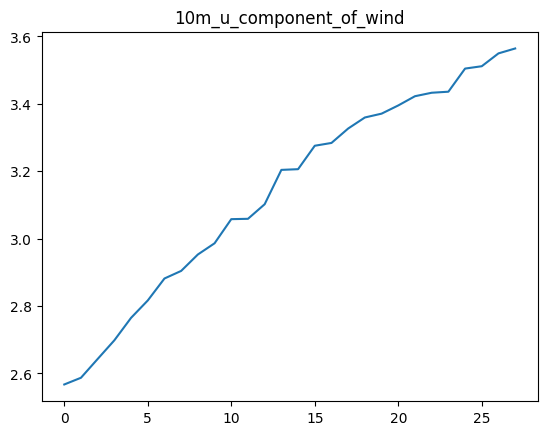

tensor(2.8293)


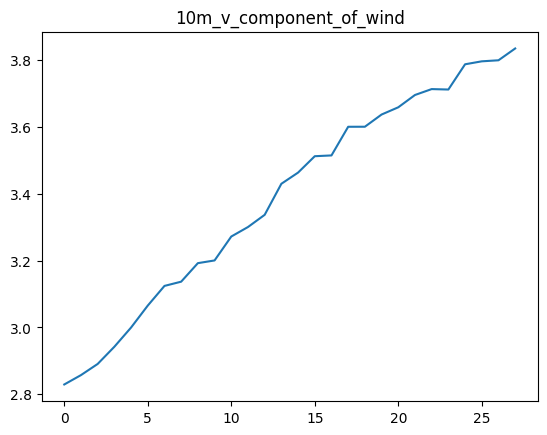

tensor(93.1331)


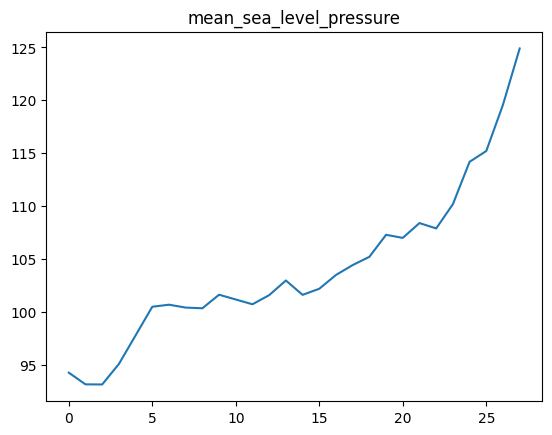

tensor(0.2904)


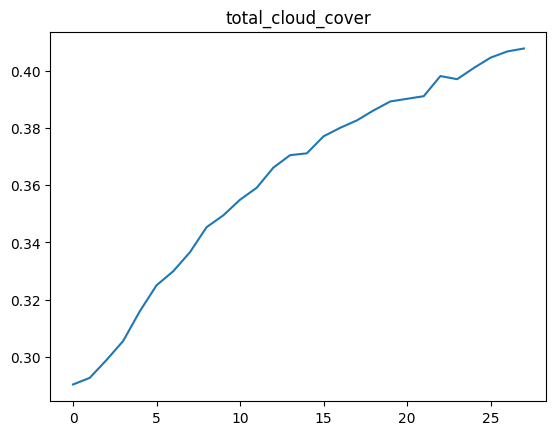

tensor(0.0004)


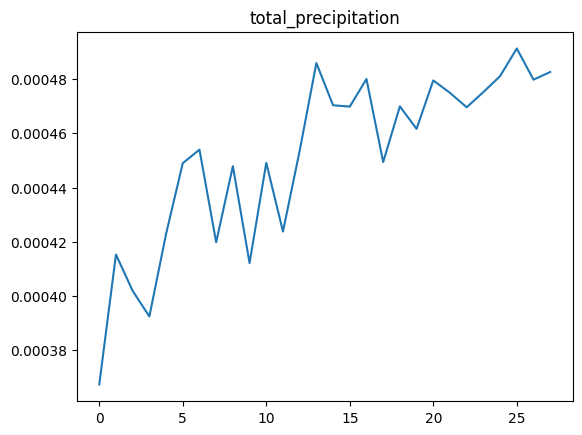

In [17]:
for var in config.training.surface_variable:
        idx = len(WeatherDataset.AIR_VARIABLE) * 37 + WeatherDataset.SURFACE_VARIABLE.index(var)
        visualize(result[idx], var)